In [12]:

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
import pandas as pd

In [13]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [15]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [16]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [17]:
x_val = x_test[:7000]
x_test = x_test[7000:]

In [18]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


#### Add noise

In [19]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [20]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

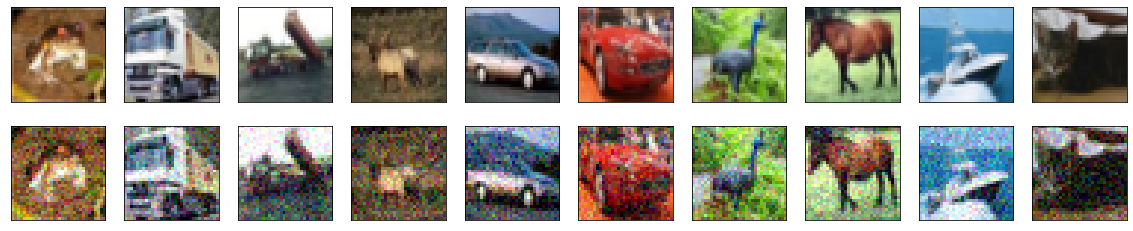

In [21]:
showOrigDec(x_train, x_train_noisy)

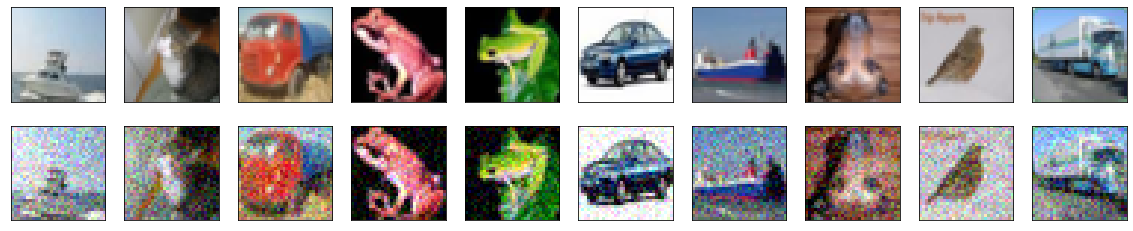

In [22]:
showOrigDec(x_train[100:], x_train_noisy[100:])

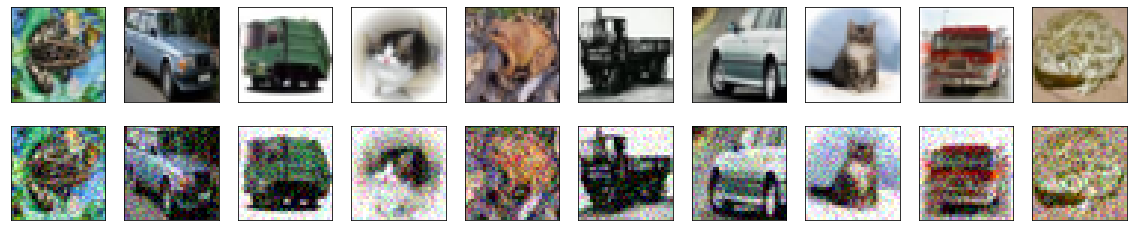

In [23]:
showOrigDec(x_train[200:], x_train_noisy[200:])

#### Convolution encoder and noisy

In [24]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [25]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
#model.load_weights(saveDir + "AutoEncoder.hdf5")

In [29]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_denoise_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [31]:
history = model.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_val_noisy, x_val),
                    shuffle=True)

Train on 50000 samples, validate on 7000 samples
Epoch 1/20
50000/50000 [==============================] - 212s 4ms/step - loss: 0.5612 - val_loss: 0.5594
Epoch 2/20
50000/50000 [==============================] - 255s 5ms/step - loss: 0.5598 - val_loss: 0.5584
Epoch 3/20
50000/50000 [==============================] - 276s 6ms/step - loss: 0.5587 - val_loss: 0.5577
Epoch 4/20
50000/50000 [==============================] - 300s 6ms/step - loss: 0.5582 - val_loss: 0.5571
Epoch 5/20
50000/50000 [==============================] - 323s 6ms/step - loss: 0.5578 - val_loss: 0.5569
Epoch 6/20
50000/50000 [==============================] - 322s 6ms/step - loss: 0.5575 - val_loss: 0.5566
Epoch 7/20
14432/50000 [=======>......................] - ETA: 3:17 - loss: 0.5581

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(x_test_noisy, x_test, verbose=1)
print(score)

#### VIsualize original and noisy

In [ ]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)

In [ ]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

In [ ]:
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
showOrigDec(x_test, x_test_noisy, c10test)